# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [17]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
#feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

# Load in the feature summary file.
#customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# azdias.columns
print(azdias.shape)
print(feat_info.shape)
print(customers.shape)

print(feat_info[:85])
# print(feat_info[3:20])
# print(feat_info[1])
print(azdias[:1])
#print(customers[:1])

print(azdias.columns)

file = open('Data_Dictionary.md').read()
# print(file)

FeatCategorical = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
FeatMixed = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
print(*FeatCategorical) 
print ("mixed features are : " 
                              + str(FeatMixed)) 
#    data_low_category = data_low[columnListCategorical].drop(['CAMEO_DEU_2015'], axis=1) #CAMEO_DEU_2015 is dropped because it has too many categories and some

(891221, 85)
(85, 4)
(191652, 85)
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numer

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.


#iterating and replacing value 

def impute_na(df, variable):
    for ind, row in feat_info.iterrows():
        attribute = row['attribute']
        missing_codes_str = row['missing_or_unknown']
        X = 'X'
        XX = 'XX'

        # For parsing string list to list
        missing_codes = eval(missing_codes_str)

        for missing_code in missing_codes:
            #print(attribute, missing_code)
            df[attribute] = df[attribute].replace(missing_code, variable)
    return df

impute_na(azdias,np.NaN)

#Saving result
# azdias.to_csv('parsed_azdias.csv', sep=';', index = False)

#reading azdias = pd.read_csv('parsed_azdias.csv', delimiter=';') azdias.head(5) ''''

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
print(azdias.head(1))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  

[1 rows x 85 columns]


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

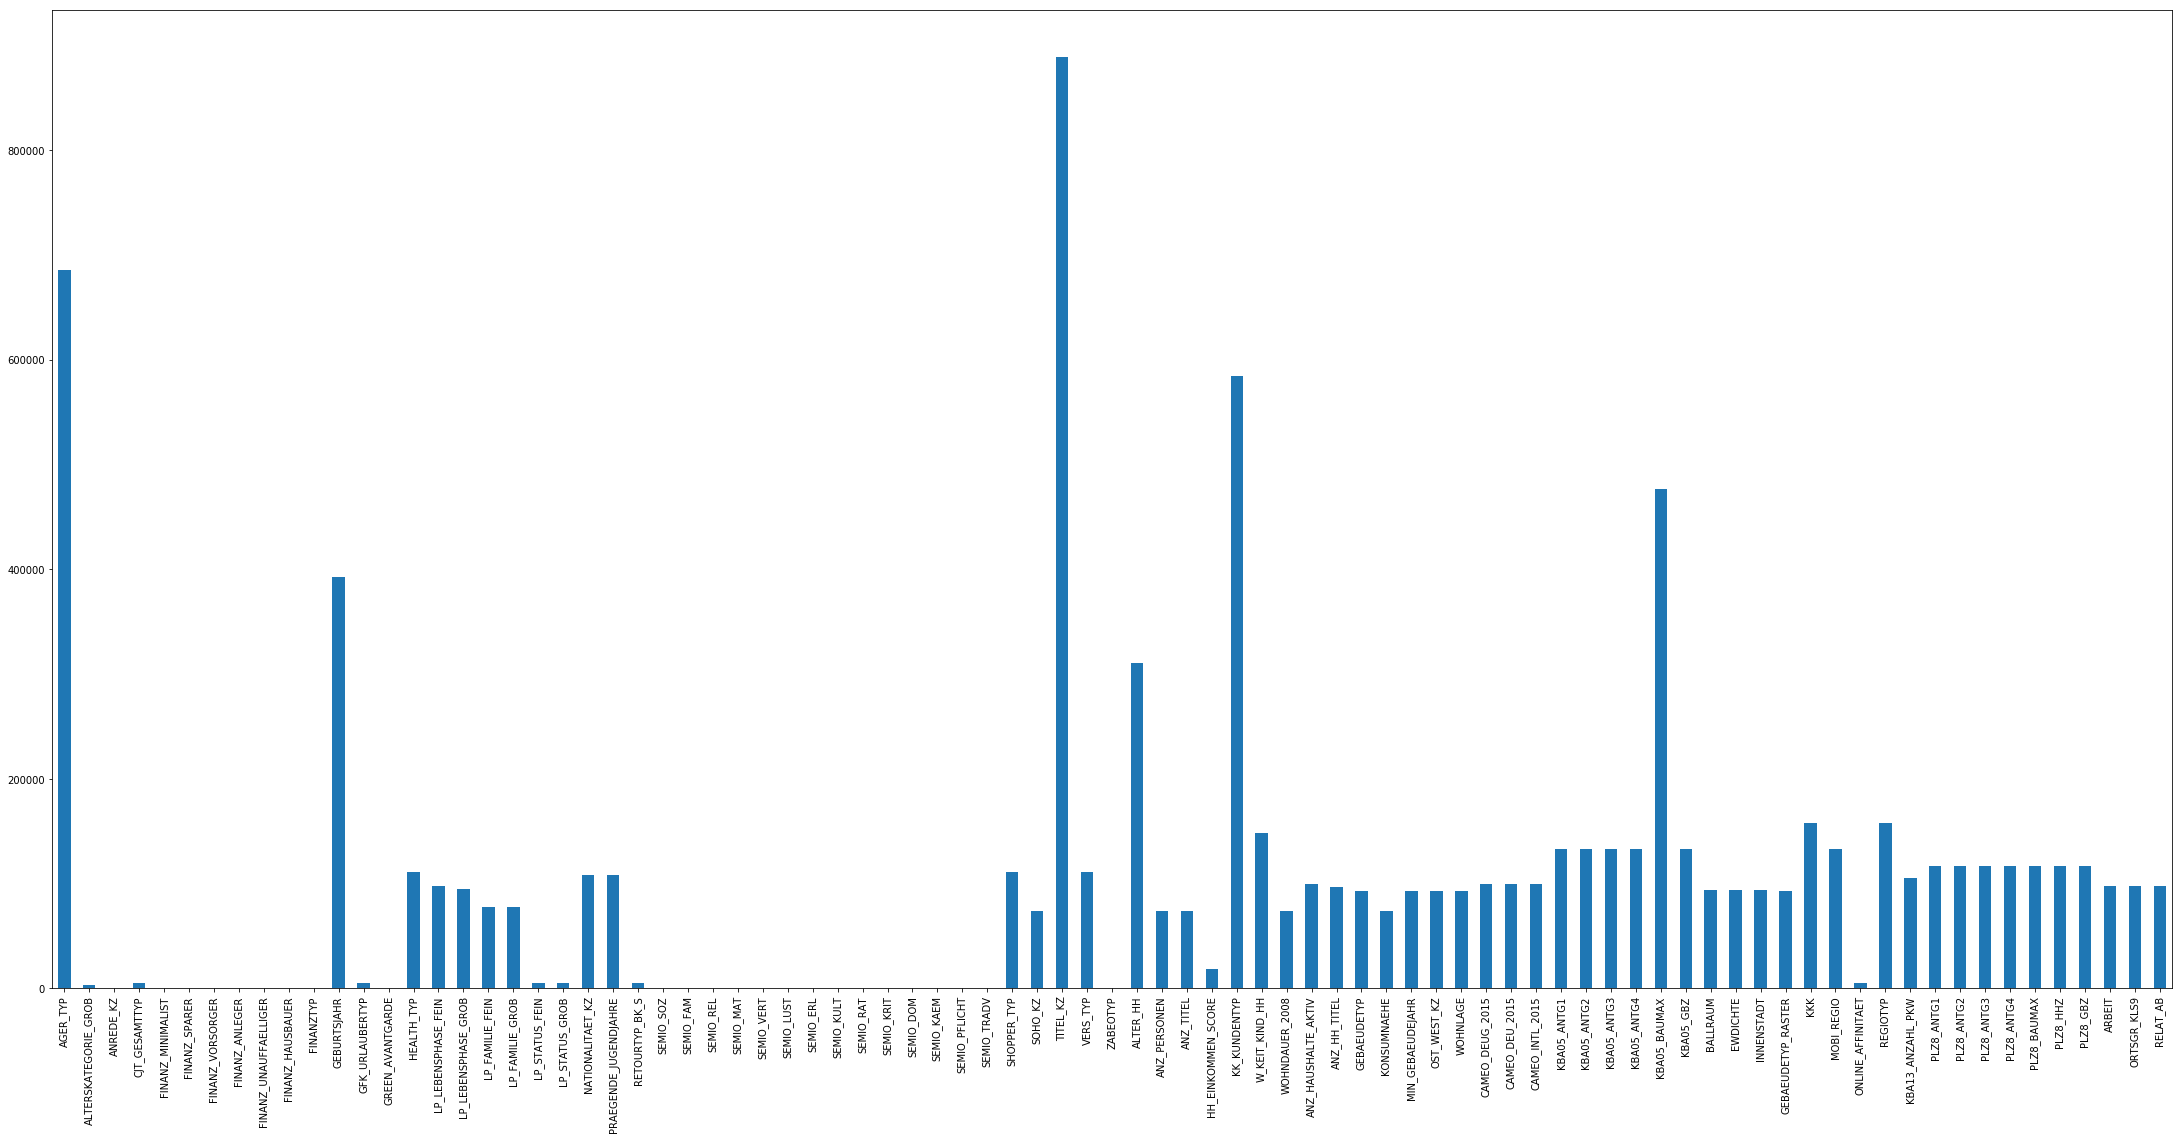

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# x = azdias.isnull().sum(); plt.hist(x, bins = 'auto')
azdias.isnull().sum().plot(kind='bar', figsize=(38,18))
#n, bins, patches = plt.hist()

In [9]:
print(azdias.count())

AGER_TYP                 205378
ALTERSKATEGORIE_GROB     888340
ANREDE_KZ                891221
CJT_GESAMTTYP            886367
FINANZ_MINIMALIST        891221
FINANZ_SPARER            891221
FINANZ_VORSORGER         891221
FINANZ_ANLEGER           891221
FINANZ_UNAUFFAELLIGER    891221
FINANZ_HAUSBAUER         891221
FINANZTYP                891221
GEBURTSJAHR              498903
GFK_URLAUBERTYP          886367
GREEN_AVANTGARDE         891221
HEALTH_TYP               780025
LP_LEBENSPHASE_FEIN      793589
LP_LEBENSPHASE_GROB      796649
LP_FAMILIE_FEIN          813429
LP_FAMILIE_GROB          813429
LP_STATUS_FEIN           886367
LP_STATUS_GROB           886367
NATIONALITAET_KZ         782906
PRAEGENDE_JUGENDJAHRE    783057
RETOURTYP_BK_S           886367
SEMIO_SOZ                891221
SEMIO_FAM                891221
SEMIO_REL                891221
SEMIO_MAT                891221
SEMIO_VERT               891221
SEMIO_LUST               891221
                          ...  
OST_WEST

891221
191652


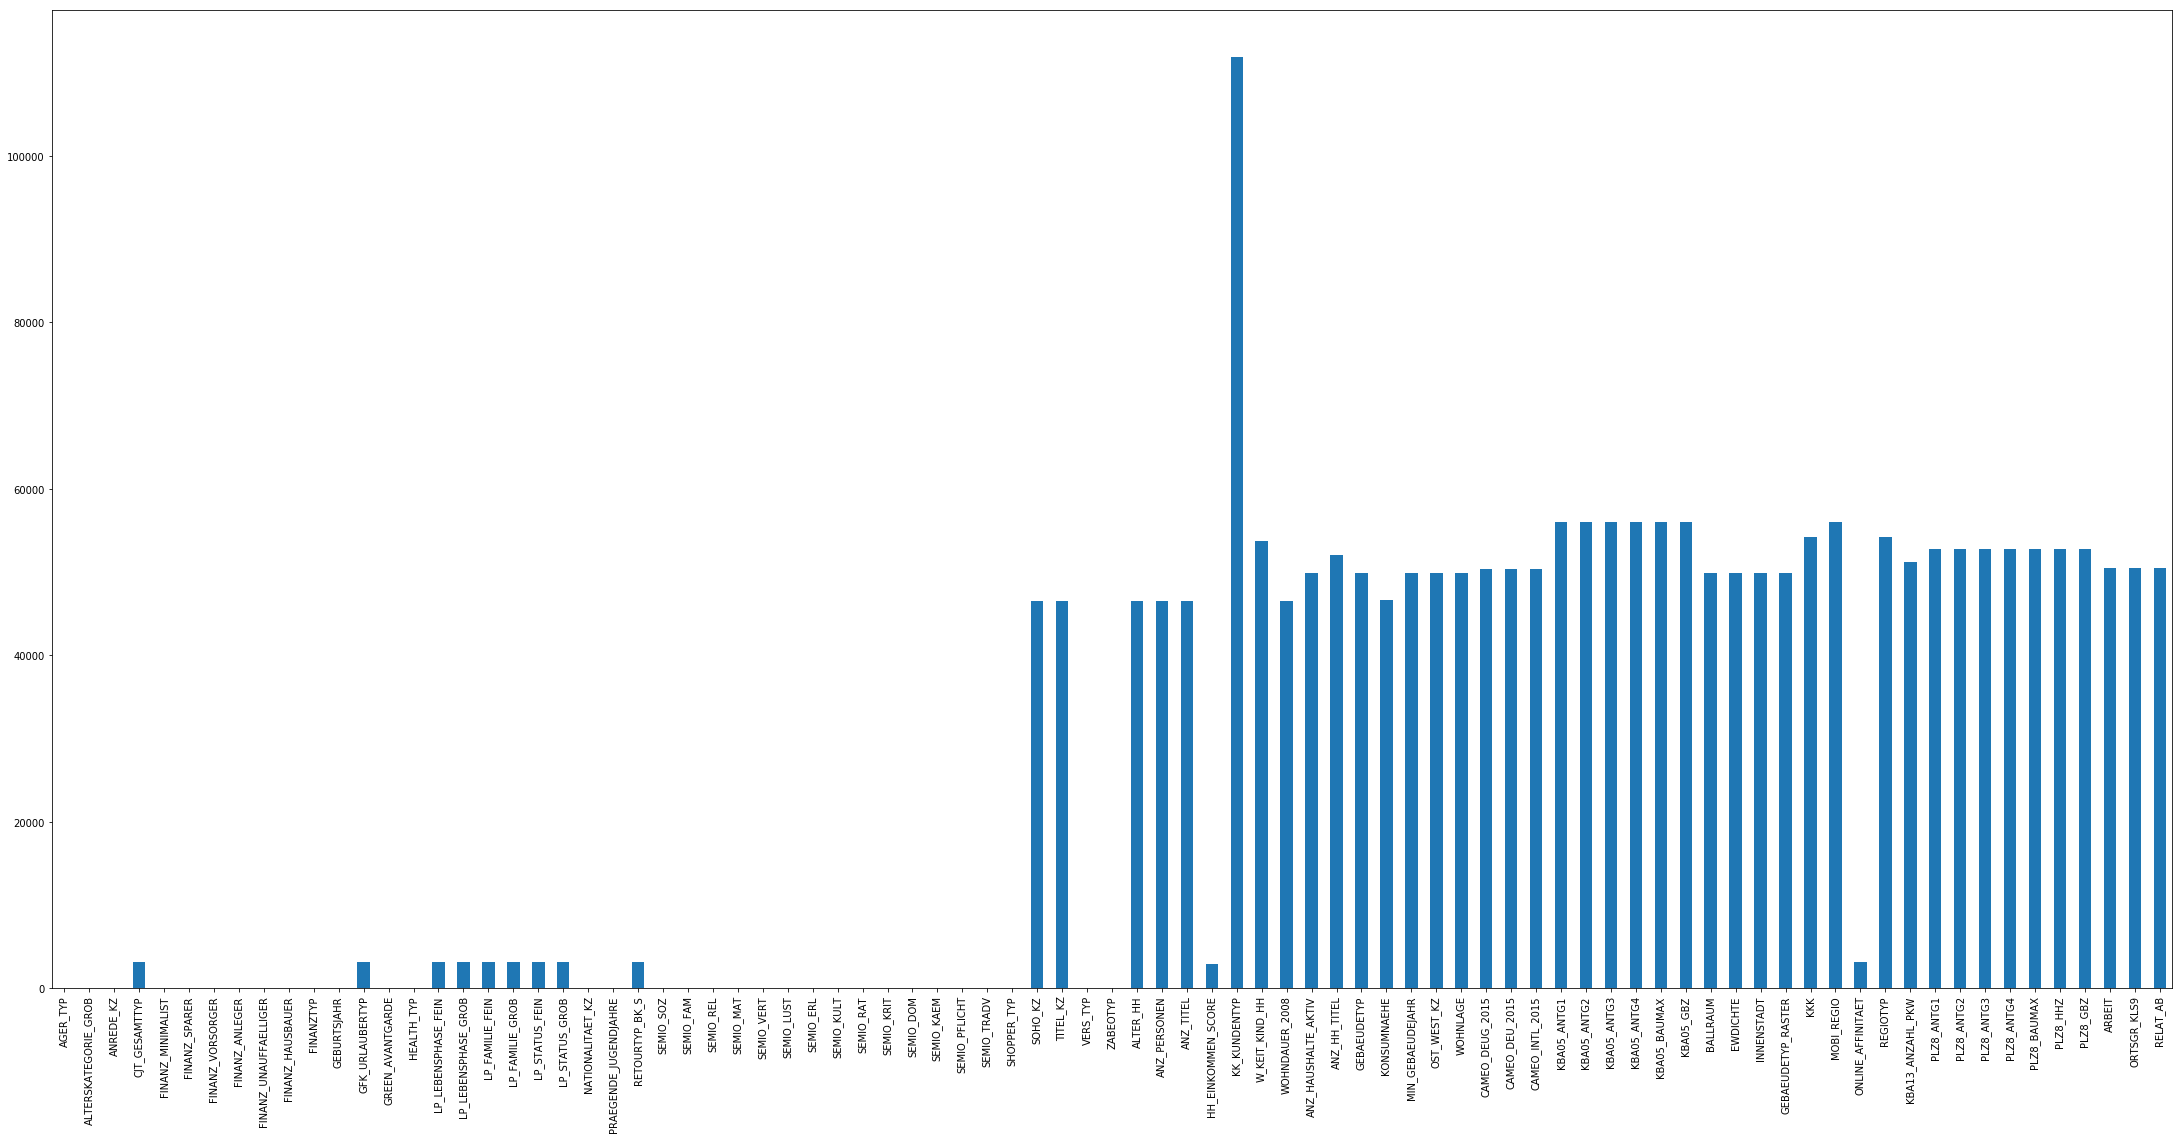

In [14]:
print(azdias.shape[0])
print(customers.shape[0])

customers.isnull().sum().plot(kind='bar', figsize=(38,18))

In [7]:
# Investigate patterns in the amount of missing data in each column.
ColumnsOutlier=azdias.columns[(azdias.isnull().sum() / azdias.shape[0]) >0.25].tolist()
print("Columns of Outlier with much NaNs for azdias is: " + str(ColumnsOutlier))

print(azdias.columns[azdias.isnull().sum()>200000])
print(azdias.isnull().sum())

ColumnsCustOutlier = customers.columns[(customers.isnull().sum() / customers.shape[0]) >0.45].tolist()  # over 45% as the outlier
print("Customers dataset Columns of Outlier with much NaNs for azdias is: " + str(ColumnsCustOutlier))

Columns of Outlier with much NaNs for azdias is: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_B

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_clean1 = azdias.dropna(axis='columns',thresh=700000) # thresh=200000)  800k non-Nan not NaN values
# azdias_clean = azdias.dropna(axis='columns',thresh=800000)   # how='any',inplace=True,thresh=None)

azdias_clean1 = azdias.drop(ColumnsOutlier,axis='columns')   # drop row by list of the outlier, those 6 columns that exceeds 25%

print(azdias_clean1.isnull().sum())
print(azdias_clean1[:1])
#azdias_clean1.isnull().sum().plot(kind='bar', figsize=(38,18))

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
                          ...  
MIN_GEBA

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The following six columns, which all have greater than 200k missing values (more than 25% of total records), are removed from dataset since they are the outlier columns.

'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'
       
The above 6 columns are derived from checking: a) either if there are more than >20k Nans for 1 column b) by checking if the # of Nans for the column are more than 25% of the total # of records for Azdias.  

(for customers dataset, there is only 1 outlier by seting threshold as >40 percent.)       

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?

x = pd.DataFrame(azdias_clean1.isnull().sum(axis=1))    # count Nans in each row
print(x.shape)
print(x.head())
# print(x.iloc[0])

#x.plot(figsize=(38,18))

#low_nulls = azdias_clean1.dropna(axis=0,thresh=38)   # 79-40=39
#print(azdias_clean1.shape)
#print(low_nulls.shape)

(891221, 1)
    0
0  43
1   0
2   0
3   7
4   0


8373929
(891221, 86)


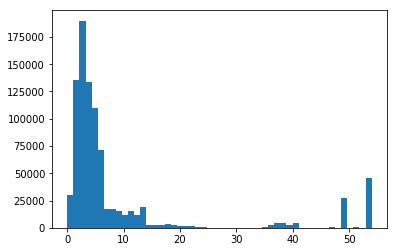

In [24]:
# another way to do the same thing as the above cell again  it is the same as x
# How much data is missing in each row of the dataset?
azdias['na_counts_row'] = azdias.isnull().sum(axis=1)
plt.hist(azdias['na_counts_row'],bins=50)   # ,figsize=(38,18)
print(azdias['na_counts_row'].sum())
print(azdias.shape)

(array([  2.63147000e+05,   4.37828000e+05,   2.93310000e+04,
          8.06700000e+03,   5.14500000e+03,   3.52000000e+02,
          1.27000000e+02,   8.16500000e+03,   8.93400000e+03,
          1.17250000e+04,   7.26800000e+03,   3.05900000e+03,
          0.00000000e+00,   5.61000000e+02,   1.54000000e+02,
          1.80500000e+03,   2.31900000e+03,   3.90500000e+03,
          3.03700000e+03,   1.28500000e+03,   3.73000000e+02,
          8.29000000e+02,   4.64000000e+02,   5.00000000e+01,
          0.00000000e+00,   3.30000000e+01,   1.80000000e+01,
          1.80000000e+01,   2.90000000e+01,   1.80000000e+01,
          1.50000000e+01,   3.00000000e+00,   5.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   2.20000000e+02,
          7.13900000e+03,   0.00000000e+00,   1.18740000e+04,
          3.16000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          7.34990000e+04,   0.00000000e+00,   4.80000000e+01,
        

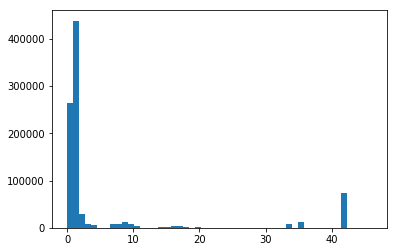

In [25]:
plt.hist(azdias.isnull().sum(axis=1),bins=50) 

5926525
(891221, 82)


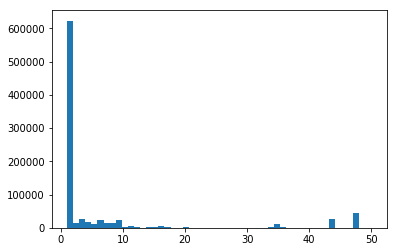

In [34]:
azdias_clean1['na_counts_row'] = azdias_clean1.isnull().sum(axis=1)
plt.hist(azdias_clean1['na_counts_row'],bins=50)   # ,figsize=(38,18)
#print(azdias_clean1['na_counts_row'].sum())
print(azdias_clean1.shape)

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold=40
# print(x[x>40])
# azdias_clean1['Nan>40'] = azdias_clean1.isnull().sum(axis=1)>40    # only the true / false no new NaNs

azdias_clean1['Nan>'] = x[x>threshold]
azdias_clean1['Nan<='] = x[x<=threshold]
azdias_clean1.head(4)
# lowNans = azdias_clean1[pd.isnull(azdias_clean1.isnull().sum(axis=1)>40)]

MoreNans = azdias_clean1.dropna(axis=0, subset=['Nan>'])
LessNans = azdias_clean1.dropna(axis=0, subset=['Nan<='])
print(MoreNans.shape)
print(LessNans.shape)

      
#na_count1=na_count[na_count['na_count']<threshold]
#na_count2=na_count[na_count['na_count']>=threshold]
#azdias1=azdias.iloc[na_count1.index,:]
#azdias2=azdias.iloc[na_count2.index,:]

#for index, row in azdias_clean1.iterrows(): 
#    #print(x[index])
#    #print(azdias_clean1[x[index]])
#    if x.iloc[index]>40:    # missing_data_per_row_dict[index] > 10: 
#        low_nulls = azdias_clean1.drop(index)
#        high_nulls = high_nulls.append(row) 

(73976, 81)
(817245, 81)


In [35]:
# The above cell is working well, yet it requires first adding two column as an indicator to seperate the records. 
# below is a better to divide without adding new columns

# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold=40
# MoreNans = azdias[x>threshold]  this won't work
MoreNans = azdias_clean1[azdias_clean1['na_counts_row']> threshold]
LessNans = azdias_clean1[azdias_clean1['na_counts_row']<=threshold]  # [x < 40] #extract rows with less than 40 missing data for further analysis

print(MoreNans.shape)
print(LessNans.shape)

(74113, 82)
(817108, 82)


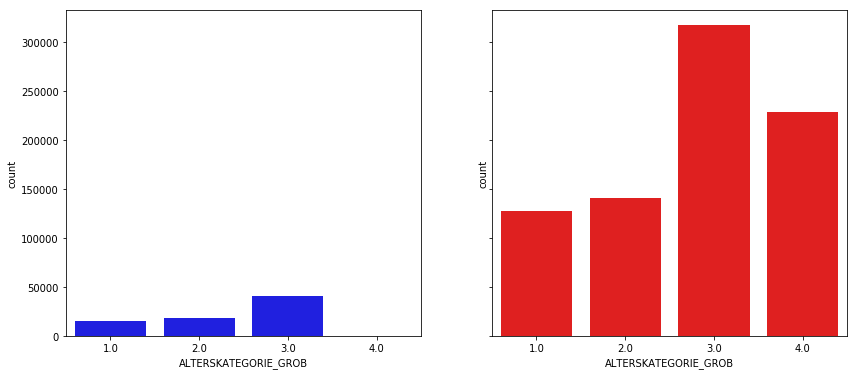

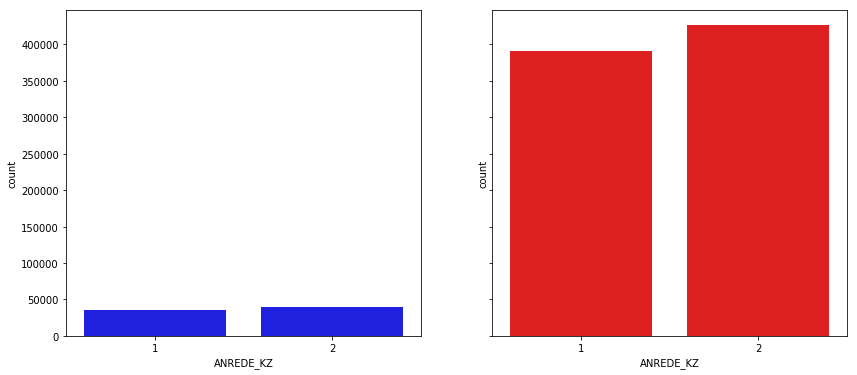

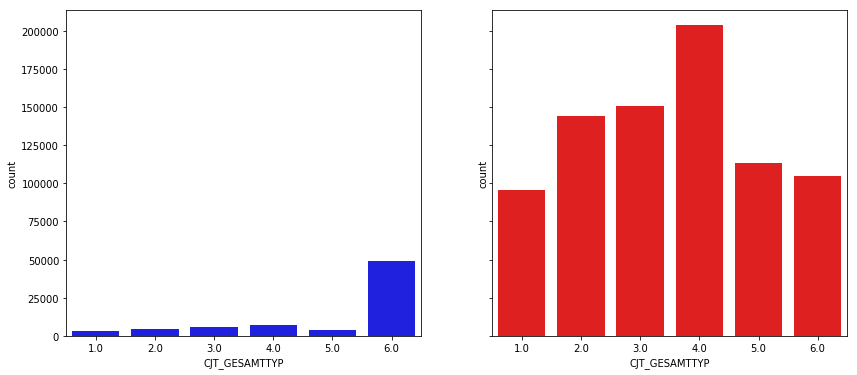

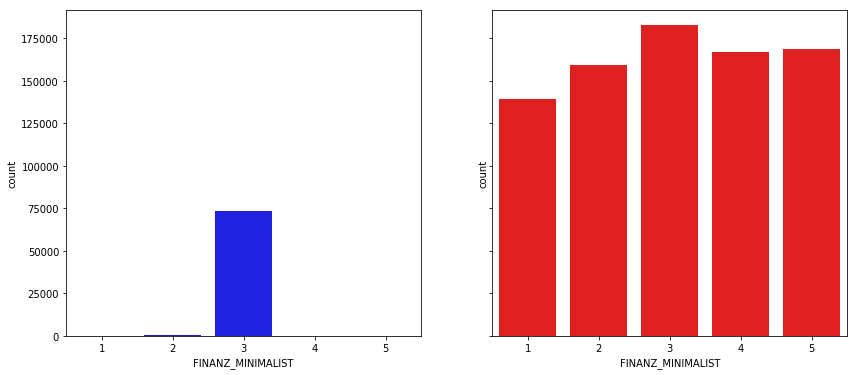

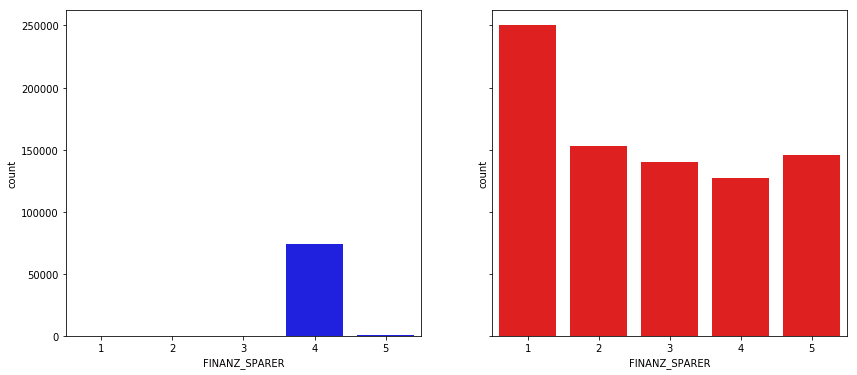

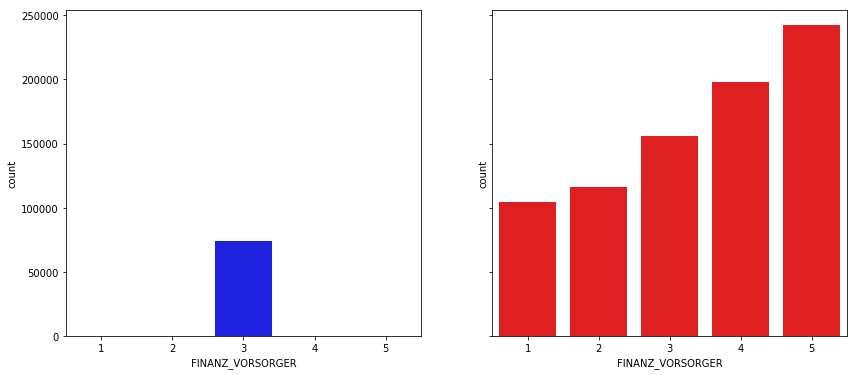

In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

cols=['ALTERSKATEGORIE_GROB', 'ANREDE_KZ',  'CJT_GESAMTTYP',  'FINANZ_MINIMALIST',  'FINANZ_SPARER',  'FINANZ_VORSORGER']

for col in cols:
    fig, axes = plt.subplots(1,2, figsize=(14, 6), sharey=True)
    sns.countplot(MoreNans[col], ax=axes[0], color='b')
    sns.countplot(LessNans[col], ax=axes[1], color='r')


#### Discussion 1.1.3: Assess Missing Data in Each Row

Reporting your observations regarding missing data in rows. 

Yes the data with lots of missing values are qualitatively different from data with few or no missing values. By reading the histogram plot of NA values in each row, I chose to use 40 as the threahold. That is, a total of 74113 rows have more than 40 missing values out of the total 85 features. I divided the datasets into two groups: the 74113 rows with 40 or more missing values in the row; and the second group of 817108 rows that have less than 40 Nans per row.

The above 5 chart compares the first 5 features head to head comparison between these two groups and shows huge differences between groups. That means it is necessary to divide, and since the more missing values rows will twist the real looking of normal cells.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [48]:
# How many features are there of each data type?
#feat_info.groupby('type').size()
print(feat_info[['attribute','type']].groupby(['type']).agg(['count']) )  # 'mean', 

            attribute
                count
type                 
categorical        21
interval            1
mixed               7
numeric             7
ordinal            49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [66]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

print(feat_info.loc[feat_info['type']=='categorical'])

# The following are binary to keep without doing
# ANREDE_KZ GREEN_AVANTGARDE SOHO_KZ VERS_TYP 


# The following are multi-level to encode
multlv = ['AGER_TYP','CJT_GESAMTTYP','FINANZTYP','LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','TITEL_KZ\
','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE','WOHNLAGE']
#'KK_KUNDENTYP', removed from column

print("multv is: " + str(multlv))

#print(ToDrop)

featMixed = feat_info[feat_info['type']=='mixed']['attribute']
print(feat_info.loc[feat_info['type']=='mixed'])
          
print(feat_info.loc[feat_info['type']=='ordinal'])    
    
#ToDrop = ['GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015','LP_LEBENSPHASE_FEIN',
#          'CAMEO_INTL_2015',\
#          'KBA05_BAUMAX','PLZ8_BAUMAX']  
            # vacation habits  family type      fine             fine type        mixed
    

           attribute information_level         type missing_or_unknown
0           AGER_TYP            person  categorical             [-1,0]
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
40    

In [55]:
# the following is to get the list of features to finally drop from the final data frame

featCategorical = feat_info[feat_info['type']=='categorical']['attribute'].tolist()
print(featCategorical)
print(len(featCategorical)) 

featMixed = feat_info[feat_info['type']=='mixed']['attribute'].tolist()
print(featMixed)
print(len(featMixed))
    
ToDrop = featCategorical

for y in featMixed:
  if y not in ToDrop:
    ToDrop.append(y)
print(len(ToDrop))

for y in ColumnsOutlier:
  if y in ToDrop:
    ToDrop.remove(y)
    
print(ToDrop)
print(len(ToDrop))

featBin = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']   # keep these binary categorical features
for y in featBin:
  if y in ToDrop:
    ToDrop.remove(y)
    
ToDrop.remove('LP_STATUS_GROB')    
print(ToDrop)
print(len(ToDrop))

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
21
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
7
28
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
24
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'NAT

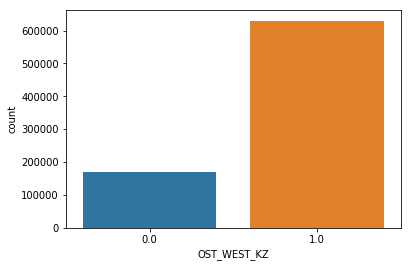

In [84]:
# Re-encode categorical variable(s) to be kept in the analysis.

#Choose to drop CAMEO_DEU_2015  because its information it has overlap with other features.
#azdias_low_category_1 = LessNans.drop(['CAMEO_DEU_2015'], axis=1) 

#azdias_low_encoded = pd.concat([azdias_low, pd.get_dummies(azdias_low_category_1.select_dtypes(include = ['object']))],axis=1)
#azdias_low_encoded = azdias_low_encoded.drop(azdias_low_category.select_dtypes(include = ['object']), axis=1)

# Re-Encode OST_WEST_KZ category with binary 0 1
LessNans['OST_WEST_KZ'] =LessNans['OST_WEST_KZ'].replace('O', 0)  # East G
LessNans['OST_WEST_KZ'] =LessNans['OST_WEST_KZ'].replace('W', 1)  # West G


sns.countplot(LessNans['OST_WEST_KZ'])

#azdias_low_dummies = pd.get_dummies(data=azdias_low, columns=binary, prefix=binary)


#### Discussion 1.2.1: Re-Encode Categorical Features

Reporting your findings and decisions regarding categorical features. 

Which ones did you keep, which did you drop, and what engineering steps did you perform?)
 
 

I keep the following features:
all binary features in the categorical, since they are low cost to keep
 ANREDE_KZ,   GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP.

I keep and re-encode the following two mixed variables
PRAEGENDE_JUGENDJAHRE
CAMEO_INTL_2015

I also keep the categorical feature LP_STATUS_GROB since this feature reflects household income and it could be influencial.

I drop the reat of the categorical and mixed features, mainly because: 
  1. many of those features are overlapping with the many other oridinal features which are providing the same information, therefore, redundant is present for those features. For example, especially some fine tune features like LP_LEBENSPHASE_FEIN are really redundant to some other oridnal features.
  2. creating dummy variable for mixed use or categorical features are quite high cost, could require dozens of more columns.

I also re-encode the binary feature OST_WEST_KZ category with binary 0 1, it was coded with string O and W. which aren't fit for feature scaling.

#azdias[attribute] = azdias[attribute].replace(missing_code, np.NaN)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

'''
def impute_na(df, variable):
    # find most frequent category
    most_frequent_category = df.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    # replace NA
    df[variable].fillna(most_frequent_category, inplace=True)
'''

In [51]:
# azdias_clean1['PRAEGENDE_JUGENDJAHRE'].value_counts()

# create new varibale: 'IsMAINSTREAM'
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([-1,0]),'IsMAINSTREAM']=np.nan
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'IsMAINSTREAM']=1
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'IsMAINSTREAM']=0

# create new varibale: 'Decade'
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([-1,0]),'Decade']=np.nan
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'Decade']=4
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'Decade']=5
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'Decade']=6
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'Decade']=7
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'Decade']=8
azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'Decade']=9

# Drop PRAEGENDE_JUGENDJAHRE
#azdias_clean1=azdias_clean1.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [54]:
print(azdias_clean1.shape)   #azdias_clean1['CAMEO_INTL_2015'].astype(float)

(891221, 90)


In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# azdias['CAMEO_INTL_2015'].value_counts()
#azdias['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].astype(float)

# create first new varibale: 'WEALTH'
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'WEALTH']=5
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'WEALTH']=4
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'WEALTH']=3
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'WEALTH']=2
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'WEALTH']=1

# create second new varibale: 'LIFE_STAGE'
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'LIFE_STAGE']=1
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'LIFE_STAGE']=2
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'LIFE_STAGE']=3
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'LIFE_STAGE']=4
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'LIFE_STAGE']=5

azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([-1,'XX']),'WEALTH']=np.nan
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([-1,'XX']),'LIFE_STAGE']=np.nan

# drop original column
#azdias_clean1=azdias_clean1.drop('CAMEO_INTL_2015',axis=1)




In [71]:
# azdias_clean1=azdias.copy(deep=True)

azdias_clean1.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'Decade']=8

# create first new varibale: 'WEALTH'
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'WEALTH']=5
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'WEALTH']=4
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'WEALTH']=3
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'WEALTH']=2
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'WEALTH']=1

# create second new varibale: 'LIFE_STAGE'
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'LIFE_STAGE']=1
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'LIFE_STAGE']=2
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'LIFE_STAGE']=3
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'LIFE_STAGE']=4
azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'LIFE_STAGE']=5
#df.loc[df['CAMEO_INTL_2015'].isin(['51','52','53','54','55']),'WEALTH']=5
#df.loc[df['CAMEO_INTL_2015'].isin(['41','42','43','44','45']),'WEALTH']=4
#df.loc[df['CAMEO_INTL_2015'].isin(['31','32','33','34','35']),'WEALTH']=3
#df.loc[df['CAMEO_INTL_2015'].isin(['21','22','23','24','25']),'WEALTH']=2
#df.loc[df['CAMEO_INTL_2015'].isin(['11','12','13','14','15']),'WEALTH']=1


    # create second new varibale: 'LIFE_STAGE'
#df.loc[df['CAMEO_INTL_2015'].isin(['11','21','31','41','51']),'LIFE_STAGE']=1
#df.loc[df['CAMEO_INTL_2015'].isin(['12','22','32','42','52']),'LIFE_STAGE']=2
#df.loc[df['CAMEO_INTL_2015'].isin(['13','23','33','43','53']),'LIFE_STAGE']=3
#df.loc[df['CAMEO_INTL_2015'].isin(['14','24','34','44','54']),'LIFE_STAGE']=4
#df.loc[df['CAMEO_INTL_2015'].isin(['15','25','35','45','55']),'LIFE_STAGE']=5

#azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([-1,'XX']),'WEALTH']=np.nan
#azdias_clean1.loc[azdias['CAMEO_INTL_2015'].isin([-1,'XX']),'LIFE_STAGE']=np.nan

# drop original column
#azdias_clean1=azdias_clean1.drop('CAMEO_INTL_2015',axis=1)




#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are 21 categorical and 7 mixed features. 

I re-engineered PRAEGENDE_JUGENDJAHRE into two new variabbles: the binary IsMAINSTREAM and the interval variable Decade. I dropped the original PRAEGENDE_JUGENDJAHRE since it is hard to disentangle completely East from West.  

I re-engineered CAMEO_INTL_2015 into two Interval variabbles: the LIFE_STAGE and the interval variable WEALTH. Then I dropped the original CAMEO_INTL_2015 since the two new variables included all information that was in the original mixed variable.

Nan was also put in accoriding to coding of the original variable.

Then I dropped all the rest.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

low

In [60]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print(multlv)
print(ToDrop)

['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE']
['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [79]:
def clean_data(Origdf):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
#    for col in range(df.shape[1]):
#        col_name=df.columns[col]
#        na_list=feat_info.iloc[col,3]
#        na_list=na_list.replace('[', '')
#       na_list=na_list.replace(']', '')
#        na_list=na_list.split(',')
#        if na_list == ['']:
#            continue
#        else:
#            for na_code in na_list:
#                if df[col_name].dtype =='object':
#                    df.loc[df[col_name]==na_code,col_name]=np.nan 
#                else:   
#                    na_code=int(na_code)
#                    df.loc[df[col_name]==na_code,col_name]=np.nan 

    df = Origdf.copy(deep=True)
    for ind, row in feat_info.iterrows():
        attribute = row['attribute']
        missing_codes_str = row['missing_or_unknown']
        X = 'X'
        XX = 'XX'

        # For parsing string list to list
        missing_codes = eval(missing_codes_str)

        for missing_code in missing_codes:
            #print(attribute, missing_code)
            df[attribute] = df[attribute].replace(missing_code, np.NaN)
        
# drop columns with too many NAs  # comment out so that it also remove the 6 columns
    # ColumnsOutlier = df.columns[(df.isnull().sum() / df.shape[0]) >0.45].tolist()
    ColumnsOutlier = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(ColumnsOutlier,axis='columns')   
    #df.drop(ColumnsOutlier,axis='columns',inplace=True)   
    
# drop rows with too many NAs
    #na_count=pd.DataFrame(customers.shape[1] - customers.count(axis=1))
    #na_count.columns=['na_count']
    #na_count=na_count[na_count['na_count']>=40]
    #customers_missing=customers.loc[na_count.index,:]
    #customers=customers.drop(na_count.index)
    df['na_counts_row'] = df.isnull().sum(axis=1)
    df = df[df['na_counts_row']<=40]   # threshold = 40

    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace('O', 0)  # East G
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace('W', 1)  # West G

    # create new varibale: 'IsMAINSTREAM'    
    # df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([-1,0]),'IsMAINSTREAM']=np.NaN
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'IsMAINSTREAM']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'IsMAINSTREAM']=0

    # create new varibale: 'Decade'
    # df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([-1,0]),'Decade']=np.NaN
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'Decade']=4
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]),'Decade']=5
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]),'Decade']=6
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]),'Decade']=7
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]),'Decade']=8
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]),'Decade']=9

    # create first new varibale: 'WEALTH'
    # no need for NaN since they -1 and xx have been converted to NaN
    # df.loc[df['CAMEO_INTL_2015'].isnull(),'WEALTH']=np.NaN

    #  df.loc[df['CAMEO_INTL_2015'].isin([-1,'XX']),'WEALTH']=np.NaN
  #  df.loc[df['CAMEO_INTL_2015'].isin([-1,'XX']),'LIFE_STAGE']=np.NaN     # np.nan is wrong and will cause hard to debug trouble

    df.loc[df['CAMEO_INTL_2015'].isin(['51','52','53','54','55']),'WEALTH']=5
    df.loc[df['CAMEO_INTL_2015'].isin(['41','42','43','44','45']),'WEALTH']=4
    df.loc[df['CAMEO_INTL_2015'].isin(['31','32','33','34','35']),'WEALTH']=3
    df.loc[df['CAMEO_INTL_2015'].isin(['21','22','23','24','25']),'WEALTH']=2
    df.loc[df['CAMEO_INTL_2015'].isin(['11','12','13','14','15']),'WEALTH']=1


    # create second new varibale: 'LIFE_STAGE'
    df.loc[df['CAMEO_INTL_2015'].isin(['11','21','31','41','51']),'LIFE_STAGE']=1
    df.loc[df['CAMEO_INTL_2015'].isin(['12','22','32','42','52']),'LIFE_STAGE']=2
    df.loc[df['CAMEO_INTL_2015'].isin(['13','23','33','43','53']),'LIFE_STAGE']=3
    df.loc[df['CAMEO_INTL_2015'].isin(['14','24','34','44','54']),'LIFE_STAGE']=4
    df.loc[df['CAMEO_INTL_2015'].isin(['15','25','35','45','55']),'LIFE_STAGE']=5


    ToDrop=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 
            'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
            'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

    #df.drop(ToDrop,axis=1,inplace=True)  # inplace cause a lot warnings, so better stick with df=df..
    df=df.drop(ToDrop,axis=1)
    df=df.drop('na_counts_row',axis=1)

    # remove selected columns and rows, ...
#    df=df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE',
#                'CAMEO_INTL_2015','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015',
#               'AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)

#    df=df.dropna(axis=0,how='any')
    
# taking the less Nan values group ??

    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [63]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#LessNans=LessNans.dropna(axis=0,how='any')
print(LessNans.shape)
#LessNans=LessNans.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','CAMEO_INTL_2015','GFK_URLAUBERTYP',
#'LP_FAMILIE_FEIN','CAMEO_DEU_2015'],axis=1)   #  'AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX','Nan>','Nan<='    ,axis=1  
#LessNans=LessNans.drop(['Nan>','Nan<='],axis=1)   #,axis=1

LessNans=LessNans.drop(ToDrop,axis=1)   #,axis=1   pd.concat(  , multlv)
#LessNans=LessNans.drop(multlv,axis=1) 
#  LessNans=LessNans.drop(['Nan>','Nan<='],axis=1)
print(LessNans.shape)
#print(LessNans.head)


(817108, 63)
(817108, 61)


In [64]:
# LessNansDel=LessNans.dropna(axis=0,how ='any')
print(LessNansDel.shape)

(632126, 61)


In [38]:
print(azdias.shape)

(891221, 85)


In [41]:
print(azdias['CAMEO_INTL_2015'])

0         NaN
1          51
2          24
3          12
4          43
5          54
6          22
7          14
8          13
9          15
10         51
11        NaN
12         43
13         33
14        NaN
15         41
16         41
17        NaN
18         24
19         34
20         24
21         55
22         51
23         43
24        NaN
25         33
26        NaN
27         51
28         13
29         12
         ... 
891191     44
891192     32
891193     43
891194     24
891195     55
891196     23
891197     24
891198     14
891199     51
891200     52
891201     41
891202     41
891203     25
891204     24
891205     34
891206     25
891207     41
891208     14
891209     51
891210     41
891211     51
891212     51
891213     34
891214     23
891215     31
891216     41
891217     51
891218     24
891219     51
891220     43
Name: CAMEO_INTL_2015, Length: 891221, dtype: object


In [29]:
plt.hist(LessNansDel.isnull().sum(axis=1),bins=50) 

AttributeError: 'function' object has no attribute 'fillna'

In [80]:
LessNansDel=clean_data(azdias)
print(LessNansDel.shape)

(817245, 64)


(623211, 64)


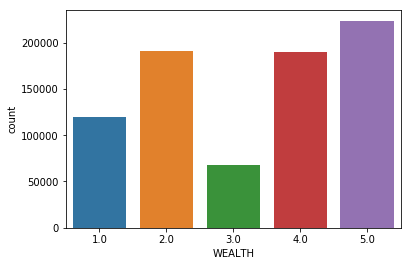

In [83]:
sns.countplot(LessNansDel['WEALTH'])
#sns.countplot(LessNansDel['LIFE_STAGE'])
LessNansDel=LessNansDel.dropna(axis=0,how ='any')
print(LessNansDel.shape)

798073


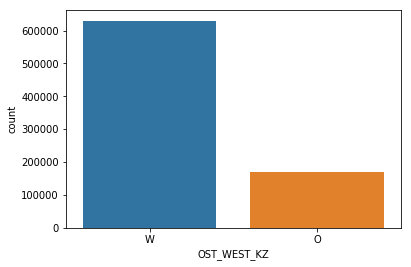

In [82]:
print(azdias['OST_WEST_KZ'].count())
sns.countplot(azdias['OST_WEST_KZ'])

In [85]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#LessNans=LessNans.iloc[:,1:155]


azdiasScaling = scaler.fit_transform(LessNansDel)
azdiasScaling=pd.DataFrame(azdiasScaling)
azdiasScaling.columns=LessNansDel.columns


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I dropped all rows that have missing values.

Though I didn't substitute those rows with either mean or median, this dropping is done after removal of the 6 columns that are outlier, after removal of mixed and categorical (except those features to keep), and after picking the less Nans group (each rows has less or equal to 40 Nans), after re-encoding.
then I delete all remaining rows that still contains any Nans.  now I get a clean dataset of LessNansDel with only 632126 rows of records, and 64 columns of features.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [102]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
azdiasPCA= pca.fit_transform(azdiasScaling)

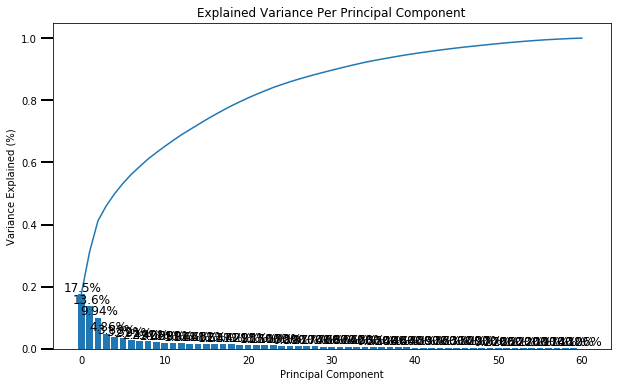

In [67]:
# Investigate the variance accounted for by each principal component.

def VarianceChart(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

VarianceChart(pca)


In [99]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=40)
azdiasPCA= pca.fit_transform(azdiasScaling)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I retain 40 components for the next step of the analysis.  
When n_components equals 60, the variance explained is more than 90%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [95]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

df=pd.DataFrame(pca.components_[0])
df.index=azdiasScaling.columns
df.columns=['PC_1']
df=df.sort_index(by=['PC_1'], ascending=False)
df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


,PC_1
PLZ8_ANTG3,0.240988
PLZ8_ANTG4,0.233638
ORTSGR_KLS9,0.216574
EWDICHTE,0.214179
HH_EINKOMMEN_SCORE,0.204080
FINANZ_HAUSBAUER,0.172533
KBA05_ANTG4,0.163563
PLZ8_ANTG2,0.161878
ARBEIT,0.153508
ANZ_HAUSHALTE_AKTIV,0.145503


In [96]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df=pd.DataFrame(pca.components_[1])
df.index=azdiasScaling.columns
df.columns=['PC_2']
df=df.sort_index(by=['PC_2'], ascending=False)
df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  import sys


,PC_2
SEMIO_ERL,0.256612
ALTERSKATEGORIE_GROB,0.256062
FINANZ_VORSORGER,0.234776
SEMIO_LUST,0.184115
RETOURTYP_BK_S,0.161831
SEMIO_KRIT,0.145186
SEMIO_KAEM,0.138501
ANREDE_KZ,0.120366
W_KEIT_KIND_HH,0.111997
FINANZ_HAUSBAUER,0.104592


In [97]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df=pd.DataFrame(pca.components_[2])
df.index=azdiasScaling.columns
df.columns=['PC_3']
df=df.sort_index(by=['PC_3'], ascending=False)
df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  import sys


,PC_3
SEMIO_VERT,0.343390
SEMIO_SOZ,0.255155
SEMIO_FAM,0.226065
SEMIO_KULT,0.205489
FINANZ_MINIMALIST,0.170428
RETOURTYP_BK_S,0.126431
FINANZ_VORSORGER,0.124958
W_KEIT_KIND_HH,0.111279
ALTERSKATEGORIE_GROB,0.101875
SEMIO_LUST,0.078209


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

PC_1 is emphasizing the family size (bigger is preferred) and community (better community) type based on features that  PLZ8_ANTG3 and PLZ_ANTG4 are representing the number of 6-10 family houses in the region, ORTSGR_KLS9 is about size of the community, EWDICHTE are representing the density of households per sq kilometer. Therefore, these big positive features shows that family and community is the PC1. On the opposite side, strong negative feature weights are MOBI_REGIO, PLZ8_ANTG1 (number of 1-2 family houses) and KBA05_ANTG1, which indicate the prevalence of buildings with smaller family capacity and financial typology. This suggests that this feature says something about the typical size of the family and community type

PC_2 is about Affinity type, financial situation and estimated age. Top positive strong features are: SEMIO_ERL (about afinity), ALTERSKATEGORIE_GROB(estimated age) and FINANZ_VORSORGER(financial). Most strong negative feature weights are HSEMIO_TRADV, SEMIO_PFLICHT, SEMIO_KULT, SEMIO_REL, which indicate that negative characters, less afinity would negatively influnce.

PC_3 is still focus on personality typology. SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT are the top positive feature, wheareas strong negative features are SEMIO_DOM,SEMIO_KAEM, and ANREDE_KZ (gender). This suggests that some other personality typology and also possibly gender will play a role in it.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [95]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
def kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score
      

Text(0.5,1,'SSE vs. K')

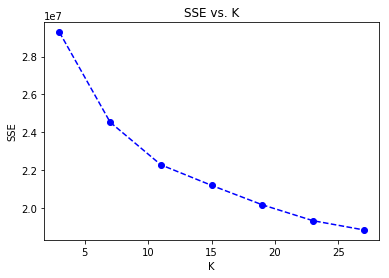

In [100]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from sklearn.cluster import KMeans

scores = []
centers = list(range(3,30,4))

for center in centers:
    scores.append(kmeans_score(azdiasPCA, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')

In [110]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=20)
model = kmeans.fit(azdiasPCA)
predict_general = model.predict(azdiasPCA)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

After trying upto various cluster centers, I found the sum of squared errors (SSE) is getting flatter after 20 cluster centers, so I choose to use 15 clusters to segment the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [86]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')
print(customers.isnull().sum(axis=1))

0          1
1         45
2          1
3          3
4          0
5          1
6          0
7          0
8          2
9          0
10        34
11         0
12         0
13         7
14         0
15         0
16         0
17         0
18         0
19         0
20         7
21         0
22         1
23         1
24         0
25         0
26         1
27         0
28         0
29         1
          ..
191622     1
191623     0
191624     0
191625     1
191626     0
191627     1
191628     1
191629     1
191630     1
191631     2
191632     0
191633     0
191634     0
191635     1
191636     0
191637     0
191638     0
191639     9
191640     0
191641     0
191642     1
191643     1
191644     0
191645     0
191646     1
191647     1
191648    10
191649     1
191650     0
191651     0
Length: 191652, dtype: int64


In [87]:
print(customers.shape)
  
print(customers.isnull().sum(axis=1))

(191652, 85)
0          1
1         45
2          1
3          3
4          0
5          1
6          0
7          0
8          2
9          0
10        34
11         0
12         0
13         7
14         0
15         0
16         0
17         0
18         0
19         0
20         7
21         0
22         1
23         1
24         0
25         0
26         1
27         0
28         0
29         1
          ..
191622     1
191623     0
191624     0
191625     1
191626     0
191627     1
191628     1
191629     1
191630     1
191631     2
191632     0
191633     0
191634     0
191635     1
191636     0
191637     0
191638     0
191639     9
191640     0
191641     0
191642     1
191643     1
191644     0
191645     0
191646     1
191647     1
191648    10
191649     1
191650     0
191651     0
Length: 191652, dtype: int64


In [88]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean=clean_data(customers)

In [89]:
print(customers_clean.shape)
print(customers_clean.isnull().sum(axis=1))

(144958, 64)
0          0
2          0
3          3
4          0
5          0
6          0
7          0
8          2
9          0
10        29
11         0
12         0
13         6
14         0
15         0
16         0
17         0
18         0
19         0
20         6
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
          ..
191622     0
191623     0
191624     0
191625     0
191626     0
191627     0
191628     0
191629     0
191630     0
191631     1
191632     0
191633     0
191634     0
191635     0
191636     0
191637     0
191638     0
191639     8
191640     0
191641     0
191642     0
191643     0
191644     0
191645     0
191646     0
191647     0
191648     9
191649     0
191650     0
191651     0
Length: 144958, dtype: int64


In [90]:
customers_clean=customers_clean.fillna(0)


# fill in NAs
#from sklearn.preprocessing import Imputer
#customers_clean[['ANZ_PERSONEN','ANZ_TITEL','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','MIN_GEBAEUDEJAHR',
#           'KBA13_ANZAHL_PKW']] = imp1.transform(customers_clean[['ANZ_PERSONEN','ANZ_TITEL',
#                                                          'ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW']])
    
#customers_clean[['SOHO_KZ','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','ONLINE_AFFINITAET',
#       'PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4']]=imp2.transform(customers_clean[['SOHO_KZ','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','ONLINE_AFFINITAET',
#       'PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4']])

# For those numeric variables having NAs, we used median to replace the NAs
#imp1 = Imputer(missing_values=np.nan , strategy='median', axis=0)
#azdias[['ANZ_PERSONEN','ANZ_TITEL','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','MIN_GEBAEUDEJAHR',
#        'KBA13_ANZAHL_PKW']]=imp1.fit_transform(azdias[['ANZ_PERSONEN','ANZ_TITEL',
#                                                        'ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL',
#                                                        'MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW']])


# For those categorical variables  having 0 in their values , we used most frequent item to replace the NAs
#imp2 = Imputer(missing_values=np.nan , strategy='most_frequent', axis=0)
#azdias[['SOHO_KZ','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','ONLINE_AFFINITAET',
#       'PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4']]=imp2.fit_transform(azdias[['SOHO_KZ','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','ONLINE_AFFINITAET',
#       'PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4']])
# 'SHOPPER_TYP' dropped in ToDrop

In [104]:
from sklearn.preprocessing import Imputer
customers2 = scaler.transform(customers_clean)
customers2=pd.DataFrame(customers2)
customers2.columns=customers_clean.columns

# PCA
customers_pca = pca.transform(customers2)
    
# clustering
predict_customers = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

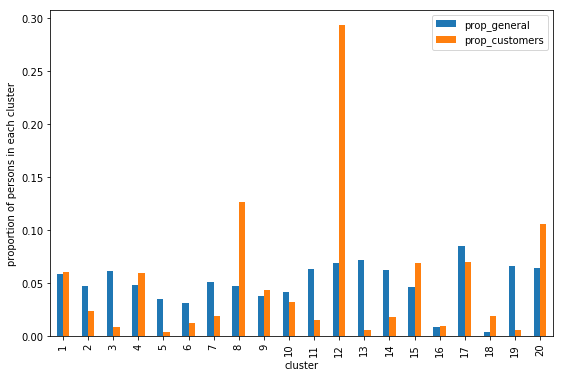

In [114]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Distribution of genaral population
general_prop = []
customers_prop = []
x = [i+1 for i in range(20)]
for i in range(20):
    general_prop.append((predict_general == i).sum()/len(predict_general))
    customers_prop.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'prop_general' : general_prop, 'prop_customers':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [116]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 8 and cluster 12 are most overrepresented in the customer data. 

data = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(predict_customers==11)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=azdiasScaling.columns)
df.head(10)




# In customer data, about 30% of all the customers belongs to cluster 12, while in genaral population, only 8 %.

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,IsMAINSTREAM,Decade,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,-0.0,5.0,1.0,3.0
1,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,-0.0,5.0,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,-0.0,5.0,2.0,3.0
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,-0.0,5.0,1.0,5.0
4,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,0.0,5.0,5.0,3.0,6.0,4.0,-0.0,7.0,1.0,5.0
5,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,1.0,...,0.0,3.0,3.0,2.0,5.0,1.0,-0.0,5.0,1.0,4.0
6,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,1.0,...,0.0,5.0,5.0,3.0,6.0,1.0,-0.0,6.0,1.0,5.0
7,4.0,1.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,1.0,...,0.0,3.0,4.0,3.0,5.0,3.0,-0.0,5.0,1.0,5.0
8,4.0,1.0,4.0,3.0,1.0,4.0,5.0,1.0,1.0,2.0,...,1.0,5.0,5.0,1.0,3.0,1.0,-0.0,9.0,1.0,4.0
9,4.0,1.0,5.0,3.0,4.0,2.0,3.0,1.0,1.0,1.0,...,0.0,3.0,4.0,4.0,6.0,5.0,-0.0,8.0,3.0,3.0


In [117]:
data_2 = scaler.inverse_transform(pca.inverse_transform(azdiasPCA[np.where(predict_general==11)])).round()
df_2 = pd.DataFrame(data=data_2,
          index=np.array(range(0, data_2.shape[0])),
          columns=azdiasScaling.columns)
df_2.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,IsMAINSTREAM,Decade,WEALTH,LIFE_STAGE
0,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,0.0,8.0,1.0,3.0
1,3.0,1.0,5.0,2.0,3.0,1.0,3.0,1.0,1.0,3.0,...,1.0,5.0,4.0,4.0,6.0,3.0,-0.0,7.0,3.0,4.0
2,3.0,1.0,4.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,...,-0.0,5.0,5.0,3.0,5.0,2.0,-0.0,8.0,1.0,5.0
3,4.0,1.0,3.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,...,-0.0,4.0,4.0,4.0,5.0,3.0,-0.0,8.0,2.0,4.0
4,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,2.0,...,1.0,3.0,3.0,4.0,6.0,3.0,-0.0,5.0,5.0,4.0
5,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,1.0,3.0,3.0,3.0,7.0,4.0,-0.0,7.0,1.0,5.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,5.0,5.0,3.0,5.0,2.0,-0.0,4.0,2.0,5.0
7,3.0,1.0,4.0,2.0,3.0,1.0,2.0,3.0,1.0,3.0,...,1.0,4.0,4.0,4.0,9.0,3.0,-0.0,7.0,1.0,5.0
8,4.0,1.0,5.0,1.0,4.0,1.0,1.0,3.0,1.0,1.0,...,0.0,3.0,5.0,4.0,9.0,3.0,-0.0,5.0,1.0,5.0
9,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,4.0,5.0,2.0,5.0,1.0,-0.0,5.0,1.0,4.0


In [ ]:
# seems this cluster belongs to older people, with average to low financial topology.

In [119]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 13 is underrepresented in the customer data. 

data_3 = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(predict_customers==12)])).round()
df = pd.DataFrame(data=data_3,
          index=np.array(range(0, data_3.shape[0])),
          columns=azdiasScaling.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,IsMAINSTREAM,Decade,WEALTH,LIFE_STAGE
0,2.0,1.0,2.0,4.0,2.0,2.0,3.0,3.0,0.0,1.0,...,2.0,3.0,1.0,3.0,8.0,5.0,1.0,9.0,4.0,1.0
1,2.0,1.0,3.0,3.0,4.0,1.0,2.0,2.0,1.0,2.0,...,0.0,3.0,3.0,4.0,8.0,4.0,-0.0,8.0,4.0,5.0
2,1.0,1.0,2.0,4.0,1.0,4.0,3.0,4.0,-0.0,3.0,...,2.0,5.0,2.0,4.0,9.0,3.0,1.0,9.0,4.0,1.0
3,1.0,1.0,5.0,2.0,3.0,1.0,4.0,3.0,-0.0,1.0,...,1.0,4.0,3.0,4.0,9.0,3.0,1.0,7.0,4.0,5.0
4,1.0,1.0,2.0,4.0,2.0,4.0,5.0,3.0,1.0,2.0,...,1.0,3.0,3.0,3.0,5.0,5.0,-0.0,9.0,5.0,4.0
5,1.0,1.0,2.0,4.0,1.0,2.0,3.0,3.0,1.0,1.0,...,2.0,5.0,3.0,3.0,7.0,5.0,-0.0,9.0,3.0,4.0
6,2.0,1.0,2.0,4.0,1.0,2.0,3.0,2.0,1.0,2.0,...,1.0,3.0,3.0,4.0,7.0,3.0,-0.0,8.0,5.0,4.0
7,1.0,1.0,1.0,5.0,3.0,5.0,4.0,5.0,-0.0,2.0,...,1.0,5.0,4.0,3.0,9.0,5.0,1.0,9.0,3.0,4.0
8,2.0,1.0,2.0,4.0,1.0,2.0,4.0,4.0,0.0,3.0,...,2.0,4.0,1.0,4.0,9.0,3.0,1.0,9.0,4.0,1.0
9,2.0,1.0,2.0,4.0,2.0,3.0,5.0,2.0,0.0,2.0,...,2.0,5.0,3.0,3.0,4.0,4.0,1.0,9.0,2.0,2.0


In [120]:
data_4 = scaler.inverse_transform(pca.inverse_transform(azdiasPCA[np.where(predict_general==12)])).round()
df = pd.DataFrame(data=data_4,
          index=np.array(range(0, data_4.shape[0])),
          columns=azdiasScaling.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,IsMAINSTREAM,Decade,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,4.0,1.0,2.0,5.0,1.0,0.0,2.0,...,2.0,4.0,3.0,5.0,7.0,5.0,1.0,8.0,5.0,5.0
1,1.0,1.0,1.0,5.0,3.0,5.0,5.0,5.0,0.0,2.0,...,1.0,4.0,3.0,4.0,5.0,5.0,1.0,9.0,5.0,1.0
2,2.0,1.0,2.0,5.0,2.0,4.0,3.0,3.0,0.0,3.0,...,1.0,3.0,3.0,4.0,5.0,5.0,1.0,8.0,4.0,1.0
3,2.0,1.0,2.0,4.0,1.0,1.0,5.0,4.0,1.0,3.0,...,2.0,4.0,3.0,3.0,9.0,4.0,-0.0,9.0,4.0,1.0
4,2.0,1.0,1.0,5.0,2.0,5.0,5.0,5.0,0.0,3.0,...,1.0,4.0,3.0,3.0,5.0,3.0,1.0,9.0,5.0,2.0
5,1.0,1.0,1.0,5.0,2.0,5.0,5.0,5.0,1.0,2.0,...,1.0,4.0,3.0,3.0,6.0,5.0,-0.0,9.0,4.0,1.0
6,2.0,1.0,2.0,5.0,2.0,4.0,4.0,3.0,-0.0,3.0,...,1.0,5.0,3.0,5.0,5.0,5.0,1.0,9.0,5.0,1.0
7,2.0,1.0,3.0,3.0,3.0,2.0,1.0,4.0,-0.0,3.0,...,2.0,5.0,2.0,4.0,9.0,3.0,1.0,7.0,2.0,5.0
8,2.0,1.0,2.0,5.0,1.0,4.0,3.0,4.0,0.0,3.0,...,2.0,3.0,1.0,4.0,9.0,3.0,1.0,9.0,4.0,1.0
9,1.0,1.0,2.0,4.0,1.0,3.0,3.0,4.0,1.0,1.0,...,2.0,4.0,1.0,4.0,9.0,3.0,-0.0,8.0,5.0,4.0


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

By looking at the plot we can see that half of clusters there is a good match between the general population and the customers population. So, the company can use this info to select a part of the general population for their business.

segments of the population that are relatively popular with the mail-order company(cluster 3): most of them are middle aged and elderly people（between 30 and 60 years old),typical house owners,household income level is average,likely to have children in household,wealth / Life Stage is likely to be middle class, unemployment level in the comunnity is relatively low.

segments of the population that are relatively unpopular with the mail-order company:cluster 0: most of them are middle aged and elderly single male（between 30 and 60 years old), low income earners,determined Minimal-Returner.

Regarding the cluster -1 (customers with too many unknown information) : customer data set has much more this kind of customers (26%) compare with population dataset (10%).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.